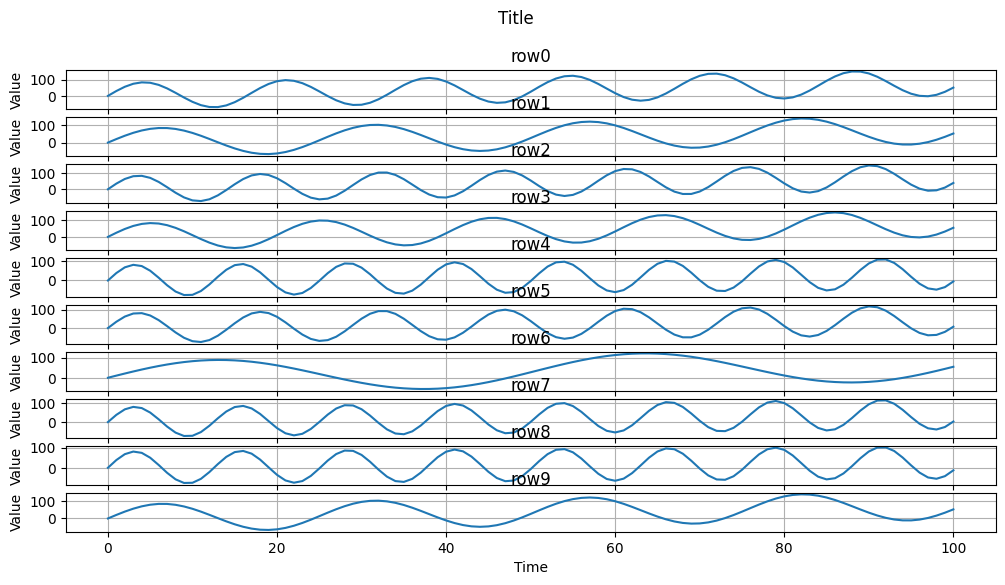

[ 4 13 21 29 38 46 55 63 72 80 88 97]
[ 6 19 32 44 57 69 82 95]
[ 4 11 18 25 33 40 47 54 61 68 76 83 90 97]
[ 5 15 25 35 46 55 66 76 86 96]
[ 3  9 16 22 28 35 41 47 54 60 66 73 79 85 92 98]
[ 4 11 18 25 32 40 47 54 61 69 76 83 90 97]
[13 37 64 88]
[ 3  9 16 22 28 35 41 47 54 60 66 73 79 85 92 98]
[ 3  9 16 22 28 35 41 47 54 60 66 73 79 85 92 98]
[ 6 19 32 44 57 69 82 95]


In [2]:
import os 
os.chdir('/root/patrec_time_series/')
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from patrec.utils import plot_series, plot_series_grid, save_config_file
from patrec.utils.files_helper import Format1_loader

# load data
loader = Format1_loader()
DATA_PATH = 'data/Synthetic_data/17_06_samples/lin_sin/sample1_10_1_0.json'
# DATA_PATH = 'data/Synthetic_data/17_06_samples/lin_saw/sample1_10_1_0.json'

sample1 = loader.load_data(DATA_PATH)
# sample1['data']

# make sample 
# sample1_sub = {
#     'row1':{'data': sample1['data'][0]},
#     'row2':{'data': sample1['data'][1]},
#     'two_rows': {'data': np.concatenate([sample1['data'][0], sample1['data'][0][-1] + sample1['data'][1][1:]])}
# }

sample1_sub = {f'row{t}':{'data': item} for t, item in enumerate(sample1['data'])}
# sample1_sub = {'row1': sample1_sub['row1']}

plot_series_grid([v['data'] for k,v in sample1_sub.items()], [k for k,v in sample1_sub.items()])

# estimate peaks 
from scipy.signal import argrelextrema

for k,v in sample1_sub.items():
    sample1_sub[k]['peaks'] = np.concatenate([argrelextrema(v['data'], np.greater), argrelextrema(v['data'], np.less)], axis=1)[0]
    sample1_sub[k]['peaks'].sort()
    print(sample1_sub[k]['peaks'])

In [ ]:
from patrec.utils.mlflow_exp import MLflowExperimentLogger

# mlflow server --backend-store-uri ".backend" --default-artifact-root ".artifacts" --host localhost --port 5000


# Statistics segmentation 

## ruptures methods

In [ ]:
from patrec.segmentation.statistics_segm import PeltSegmentor, BinSegSegmentor, KernelCPDSegmentor

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score


In [15]:
# Пример использования:
true_cps = [100, 200, 300, 301]
pred_cps = [98, 210, 305, 301, 400]

model = PeltSegmentor()

y_true, y_pred = model.target_paddding(true_cps, pred_cps, tolerance=5)
accuracy, precision, recall, f1 = accuracy_score(y_true, y_pred), recall_score(y_true, y_pred), recall_score(y_true, y_pred), f1_score(y_true, y_pred)

print(true_cps, pred_cps)
print(y_true, y_pred)
print(f"Accuracy:{accuracy:.2f} ,Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}")


[100, 200, 300, 301] [98, 210, 305, 301, 400]
[1, 1, 1, 1, 0, 0] [1, 0, 1, 1, 1, 1]
Accuracy:0.50 ,Precision: 0.75, Recall: 0.75, F1: 0.67


In [8]:
from patrec.feature_extraction.manual_methods.trend_decomposition import STL_detrender

In [19]:
# min_size controls the minimum distance between change points; for instance, if min_size=10, all change points will be at least 10 samples apart.
# jump controls the grid of possible change points; for instance, if jump=k, only changes at k, 2*k, 3*k,... are considered.

model = PeltSegmentor(model='l1', min_size=10, jump=5)

for k,v in sample1_sub.items():
    for pen in range(5,100, 20):
        detr = STL_detrender(5)
        row = detr.extract(v['data'])
        sample1_sub[k]['detrended'] = row.results['detrended']
        sample1_sub[k][f'Pelt_{pen}'] =  model.infer(sample1_sub[k]['detrended'], pen)


5
25
45
65
85


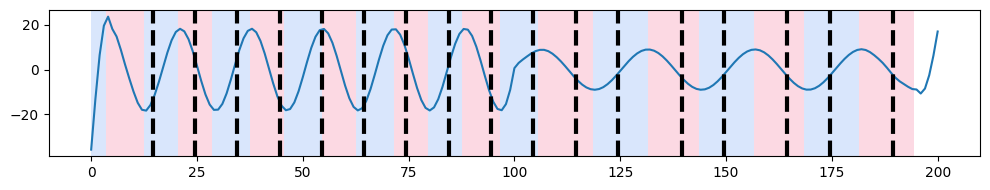

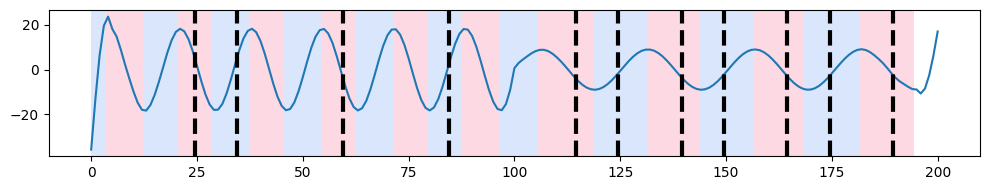

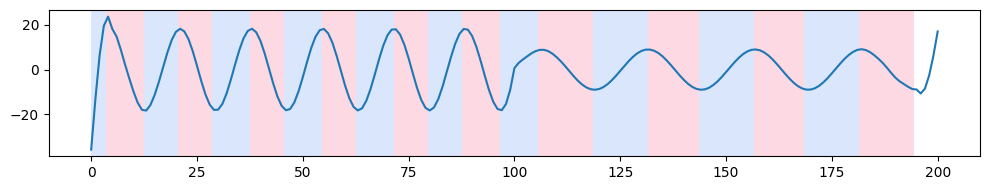

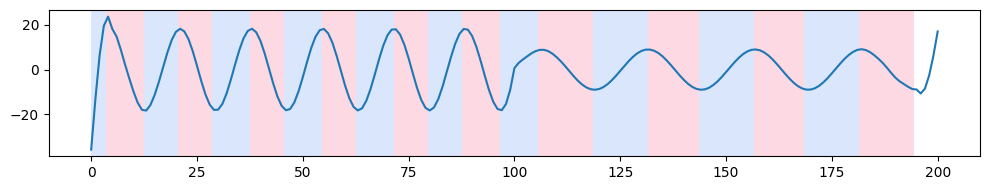

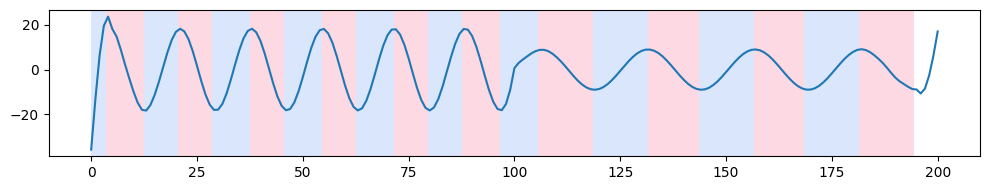

In [20]:
import ruptures as rpt 

k = 'two_rows'

for pen in range(5,100, 20):
    print(pen)
    rpt.display(sample1_sub[k]['detrended'], sample1_sub[k]['peaks'], sample1_sub[k][f'Pelt_{pen}'])